[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pandat8/INDU-498/blob/main/ModelEvaluationAndSelection_ldf.ipynb)

# Model Evaluation and Selection

We are going to work a simulated dataset using the following function, which simulates 90 "normal" samples and 90 "cancer" samples from a two-dimensional Gaussian distributions.

Note that the normal samples are sampled from 3 different Gaussian distributions with different means and covariances whereas the cancer samples are sampled from 2 different Gaussian distributions.

In [5]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
np.random.seed(1234)

import warnings
warnings.filterwarnings('ignore')

In [6]:
def simulate_prostate_cancer_data():
    # simulate normal samples
    npoints = 600
    means=[70,70]
    #cov = [[90,40],[40,50]]
    cov = [[120,60],[60,50]]
    np.random.seed(3)

    normal1 = np.random.multivariate_normal(means,cov, npoints)
    labels_normal1 = np.zeros((npoints, 1))
    npoints = 600
    means=[140,60]
    #cov = [[90,40],[40,50]]
    cov = [[160,30],[30,50]]

    normal2 = np.random.multivariate_normal(means,cov, npoints)
    labels_normal2 = np.zeros((npoints, 1))

    npoints = 600
    means=[250,110]
    #cov = [[90,40],[40,50]]
    cov = [[300,30],[30,30]]

    normal3 = np.random.multivariate_normal(means,cov, npoints)
    labels_normal3 = np.zeros((npoints, 1))

    normal=np.concatenate((normal1,normal2,normal3))
    labels_normal=np.concatenate((labels_normal1,labels_normal2,labels_normal3))

    # simulate cancer samples
    npoints = 450
    means=[155,80]
    #cov = [[150,50],[50,50]]
    cov = [[4000,-600],[-600,50]]

    cancer1 = np.random.multivariate_normal(means,cov, npoints)
    labels_cancer1 = np.ones((npoints, 1))

    npoints = 450
    means=[50,80]
    #cov = [[150,50],[50,50]]
    cov = [[40,-60],[-60,50]]

    cancer2 = np.random.multivariate_normal(means,cov, npoints)
    labels_cancer2 = np.ones((npoints, 1))

    cancer=np.concatenate((cancer1,cancer2))
    labels_cancer=np.concatenate((labels_cancer1,labels_cancer2))

    X= np.concatenate((normal,cancer), axis=0)
    y = np.concatenate((labels_normal,labels_cancer), axis=0).squeeze() # to (N,)

    return X, y

X,y = simulate_prostate_cancer_data()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1, shuffle=True)

We can visualize the simulated data points as follows.

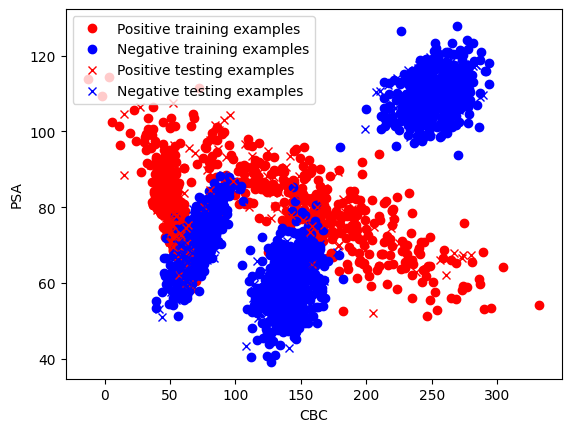

In [8]:
plt.clf()
positive_train = y_train==1
negative_train = y_train==0

positive_test = y_test==1
negative_test = y_test==0

plt.plot(X_train[positive_train,0],X_train[positive_train,1],"or",label="Positive training examples")
plt.plot(X_train[negative_train,0],X_train[negative_train,1],"ob",label="Negative training examples")

plt.plot(X_test[positive_test,0],X_test[positive_test,1],"xr",label="Positive testing examples")
plt.plot(X_test[negative_test,0],X_test[negative_test,1],"xb",label="Negative testing examples")

plt.xlabel("CBC")
plt.ylabel("PSA")
plt.legend(loc='best')
plt.savefig("train_test_scatterplot.png", bbox_inches='tight', dpi=300)

Instead of importing our implementation of `KNN`, to keep things simple, let's use `scikit-learn`'s `KNN` implementation.

In [9]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier() # n_neighbors=5 (default)
fit = knn.fit(X_train, y_train)

Evaluate the prediction accuracy on training and testing as follows

In [10]:
y_train_pred = fit.predict(X_train)
y_test_pred = fit.predict(X_test)

acc_train = np.sum(y_train_pred==y_train)/len(y_train)
acc_test = np.sum(y_test_pred==y_test)/len(y_test)

print(acc_train)
print(acc_test)

0.961574074074074
0.9425925925925925


In [12]:
def plot_2d_classification(classifier, X, fill=False, ax=None, eps=None, alpha=1):
    # multiclass
    if eps is None:
      eps = X.std() / 2.

    if ax is None:
      ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    decision_values = classifier.predict(X_grid)
    ax.imshow(decision_values.reshape(X1.shape), extent=(x_min, x_max,
                                                       y_min, y_max),
            aspect='auto', origin='lower', alpha=alpha)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.neighbors import KNeighborsClassifier
# fig, axes = plt.subplots(2, 2, figsize=(8, 8))
# for ax, n_neighbors in zip(axes.ravel(), [1, 5, 10, 15]):
#     ax.set_title(f"n_neighbors={n_neighbors}")
#     clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)
#     ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k')
#     plot_2d_classification(clf, X, ax=ax, alpha=.5)
#     ax.set_aspect("equal")
# plt.savefig("knn_boundary_varying_k.png", bbox_inches='tight')

## Generalization error
What we really care about is the performance of the model on new data.
In other words, we want to see how our model **generalizes** to unseen data.
An assumption that justifies deployment of our model on unseen data is the fact that our training and deployment data come from the *same* distribution. In fact very often we assume that there exists some distribution $p(x,y)$ over our features and labels, such that our training data is composed of independent samples from this distribution -- that is $x^{(n)}, y^{(n)} \sim p(x, y)$ for all $x^{(n)}, y^{(n)} \in \mathcal{D}$. We assume that unseen data are also samples from the same distribution.

**Generalization error** is the *expected error* of our model $f: x \mapsto y$ under this distribution:
$$
Err(f) = \mathbb{E}_{x,y \sim p}[\ell(f(x), y)].
$$
Here $\ell$ is some *loss function* such as classification error $\ell(y, \hat{y}) = \mathbb{I}(y \neq \hat{y})$ or square loss $\ell(y, \hat{y}) = (y - \hat{y})^2$ that we often use in regression.

## Test set
Unfortunately, we don't have access to the true data distribution, we only have samples from this dataset. We can estimate the generalization error by setting aside a portion of our dataset that **we do not using in any way in learning or selecting the model**. This part of the dataset is called the **test set**. Let's use $\mathcal{D}_{\text{train}}$ and $\mathcal{D}_{\text{test}}$ to this partitioning of our original dataset $\mathcal{D}$. The **test error** is
$$
\widehat{Err}(f) = \mathbb{E}_{x, y \sim \mathcal{D}_{\text{test}}}[\ell(f(x), y)] = \frac{1}{|\mathcal{D}_{\text{test}}|} \sum_{x,y \in \mathcal{D}_{\text{test}}} \ell(f(x), y).
$$

## Model selection using validation data

We can split the data twice:
	1. first split the entire data into training and testing set
	2. then split the training data into training and validation set


In [36]:
X_train_all, X_test, y_train_all, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=11)

X_train, X_valid, y_train, y_valid = \
    train_test_split(X_train_all, y_train_all, test_size=1/8, random_state=11)

Use validation data to choose K in the range from 1 to 10

0.9592592592592593


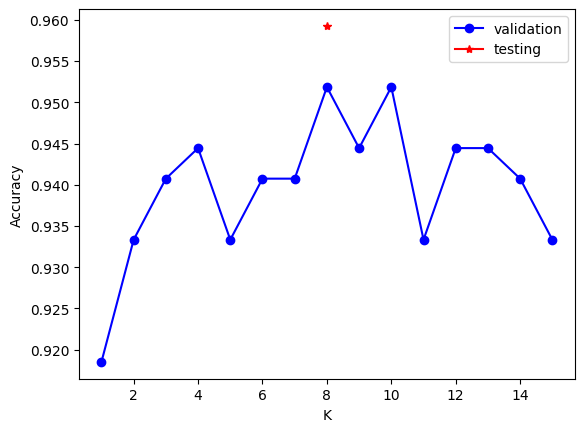

In [48]:
model_choices=[]
valid_acc = []
train_acc = []

n_valid = y_valid.shape[0]
n_train = y_train.shape[0]

for k in range(1,16):
    knn = KNeighborsClassifier(n_neighbors=k) # create a KNN object (OOP)
    knn.fit(X_train, y_train)
    y_valid_pred = knn.predict(X_valid)
    accuracy_valid = np.sum(y_valid_pred == y_valid)/n_valid
    y_train_pred = knn.predict(X_train)
    accuracy_train = np.sum(y_train_pred == y_train)/n_train
    model_choices.append(k)
    valid_acc.append(accuracy_valid)
    train_acc.append(accuracy_train)

# use the best K to predict test data
best_valid_K = model_choices[valid_acc.index(max(valid_acc))]
knn = KNeighborsClassifier(n_neighbors=best_valid_K)
knn.fit(X_train_all, y_train_all)
y_test_pred = knn.predict(X_test)
test_accuracy = np.sum(y_test_pred == y_test)/y_test.shape[0]
print(test_accuracy)

plt.clf()
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_valid_K, test_accuracy, marker='*', color='red', label='testing')
# plt.plot(model_choices, train_acc, marker='o', color='green', label='validation')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')

# plt.show()
plt.savefig("training_validation_testing_0.png",bbox_inches='tight', dpi=300)

## True/false positive rates

True negative (TN)
* Negative example that is predicted to be negative
* A person who is predicted to be healthy and in fact is healthy

False positive (FP)
* Negative example that is predicted to be positive
* A person who is predicted to have cancer but in fact is healthy

False negative (FN)
* Positive example that is predicted to be negative
* A person who is predicted to be healthy but in fact has cancer

True positive (TP)
* Positive example that is predicted to be positive
* A person who is predicted to have cancer and in fact has cancer

We can compute a confusion matrix that contains TN, FP, FN, and TP as follows.

In [38]:
import pandas as pd
### confusion matrix ###
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)

cm_df = pd.DataFrame(cm, index=['Actual Negative','Actual Positive'],
                     columns=['Predicted Negative', 'Predicted Positive'])
print(cm_df)

                 Predicted Negative  Predicted Positive
Actual Negative                 350                   4
Actual Positive                  18                 168


# Cross validation

In our above example, we split the data into training and testing set. This is quite wasteful because we sacrifice half of the data. To evaluate the data on *every data point*, we can perform K-fold cross-validation.

<img src="https://github.com/yueliyl/comp551-notebooks/blob/master/kfold_cv/cross_validation.png?raw=1" width=1200>

<img src="https://github.com/yueliyl/comp551-notebooks/blob/master/kfold_cv/cross_validation_2.png?raw=1" width=1000>

[[349   5]
 [ 14 172]]
Recall: 0.9247311827956989
Precision: 0.9717514124293786
F1-score: 0.9476584022038568
Accuracy: 0.9648148148148148


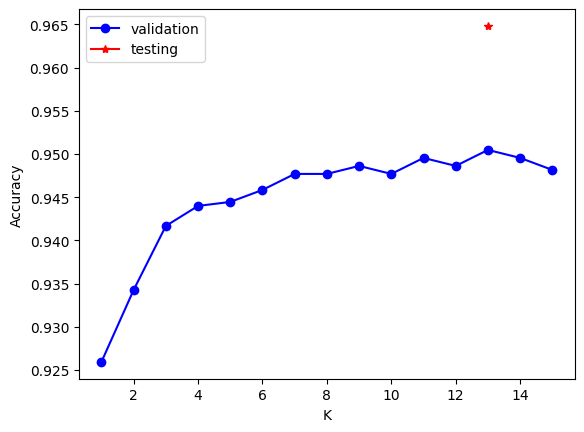

In [49]:
from sklearn.model_selection import KFold
model_choices=[]
valid_acc = []

n = y_train_all.shape[0]

def cross_validate(model, X_input, Y_output):
    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    y = np.array([0] * X_input.shape[0])
    yh = np.array([0.0] * X_input.shape[0])
    for train_index, test_index in kf.split(X_input):
        model.fit(X_input[train_index], Y_output[train_index])
        y[test_index] = Y_output[test_index]
        yh[test_index] = model.predict(X_input[test_index])
    return y, yh

for k in range(1,16):
    knn = KNeighborsClassifier(n_neighbors=k) # create a KNN object (OOP)
    true_labels, pred_scores = cross_validate(knn, X_train_all, y_train_all)
    accuracy = np.sum(pred_scores == true_labels)/n
    model_choices.append(k)
    valid_acc.append(accuracy)

# use the best K to predict test data
best_valid_K = model_choices[valid_acc.index(max(valid_acc))]
knn = KNeighborsClassifier(n_neighbors=best_valid_K)
knn.fit(X_train_all, y_train_all)
y_test_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred)
print(cm)
recall = cm[1,1]/(cm[1,1]+cm[1,0])
precision = cm[1,1]/(cm[1,1]+cm[0,1])
test_f1_score = f1_score(y_test, y_test_pred)
test_accuracy = np.sum(y_test_pred == y_test)/y_test.shape[0]
print('Recall:', recall)
print('Precision:', precision)
print('F1-score:', test_f1_score)
print('Accuracy:', test_accuracy)

plt.clf()
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_valid_K, test_accuracy, marker='*', color='red', label='testing')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')

# plt.show()
plt.savefig("training_crossvalidation_testing.png",bbox_inches='tight', dpi=300)

[[349   5]
 [ 14 172]]
Recall: 0.9247311827956989
Precision: 0.9717514124293786
F1-score: 0.9476584022038568
Accuracy: 0.9648148148148148


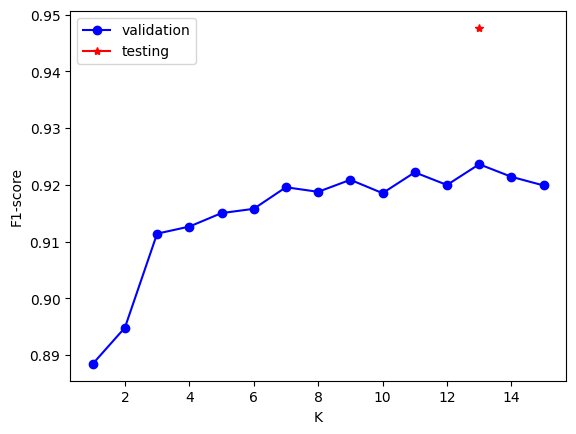

In [50]:
from sklearn.model_selection import KFold
import pandas as pd
### confusion matrix ###
from sklearn.metrics import f1_score, confusion_matrix

model_choices=[]
valid_acc = []


# cm_df = pd.DataFrame(cm, index=['Actual Negative','Actual Positive'],
#                      columns=['Predicted Negative', 'Predicted Positive'])
# print(cm_df)

n = y_train_all.shape[0]

def cross_validate(model, X_input, Y_output):
    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    y = np.array([0] * X_input.shape[0])
    yh = np.array([0.0] * X_input.shape[0])
    for train_index, test_index in kf.split(X_input):
        model.fit(X_input[train_index], Y_output[train_index])
        y[test_index] = Y_output[test_index]
        yh[test_index] = model.predict(X_input[test_index])
    return y, yh

for k in range(1,16):
    knn = KNeighborsClassifier(n_neighbors=k) # create a KNN object (OOP)
    true_labels, pred_scores = cross_validate(knn, X_train_all, y_train_all)
    accuracy = np.sum(pred_scores == true_labels)/n
    f1_value = f1_score(true_labels, pred_scores)
    model_choices.append(k)
    valid_acc.append(f1_value)

# use the best K to predict test data
best_valid_K = model_choices[valid_acc.index(max(valid_acc))]
knn = KNeighborsClassifier(n_neighbors=best_valid_K)
knn.fit(X_train_all, y_train_all)

y_test_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred)
print(cm)
recall = cm[1,1]/(cm[1,1]+cm[1,0])
precision = cm[1,1]/(cm[1,1]+cm[0,1])
test_f1_score = f1_score(y_test, y_test_pred)
test_accuracy = np.sum(y_test_pred == y_test)/y_test.shape[0]
print('Recall:', recall)
print('Precision:', precision)
print('F1-score:', test_f1_score)
print('Accuracy:', test_accuracy)

plt.clf()
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_valid_K, test_f1_score, marker='*', color='red', label='testing')
plt.xlabel("K")
plt.ylabel("F1-score")
plt.legend(loc='best')

# plt.show()
plt.savefig("training_crossvalidation_testing_f1.png",bbox_inches='tight', dpi=300)

[[348   6]
 [ 13 173]]
Recall: 0.9301075268817204
Precision: 0.9664804469273743
F1-score: 0.947945205479452
Accuracy: 0.9648148148148148


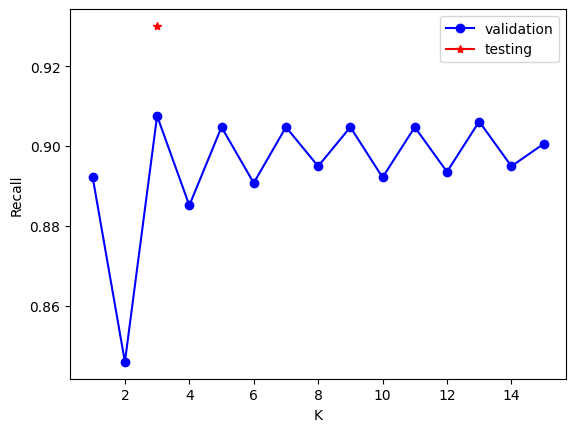

In [51]:
from sklearn.model_selection import KFold
import pandas as pd
### confusion matrix ###
from sklearn.metrics import f1_score, confusion_matrix

model_choices=[]
valid_acc = []


# cm_df = pd.DataFrame(cm, index=['true negatives','false positive'],
#                      columns=['false negative', 'true positive'])
# print(cm_df)

n = y_train_all.shape[0]

def cross_validate(model, X_input, Y_output):
    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    y = np.array([0] * X_input.shape[0])
    yh = np.array([0.0] * X_input.shape[0])
    for train_index, test_index in kf.split(X_input):
        model.fit(X_input[train_index], Y_output[train_index])
        y[test_index] = Y_output[test_index]
        yh[test_index] = model.predict(X_input[test_index])
    return y, yh

for k in range(1,16):
    knn = KNeighborsClassifier(n_neighbors=k) # create a KNN object (OOP)
    true_labels, pred_scores = cross_validate(knn, X_train_all, y_train_all)
    accuracy = np.sum(pred_scores == true_labels)/n
    cm = confusion_matrix(true_labels, pred_scores)
    recall = cm[1,1]/(cm[1,1]+cm[1,0])
    model_choices.append(k)
    valid_acc.append(recall)

# use the best K to predict test data
best_valid_K = model_choices[valid_acc.index(max(valid_acc))]
knn = KNeighborsClassifier(n_neighbors=best_valid_K)
knn.fit(X_train_all, y_train_all)

y_test_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred)
print(cm)
recall = cm[1,1]/(cm[1,1]+cm[1,0])
precision = cm[1,1]/(cm[1,1]+cm[0,1])
test_f1_score = f1_score(y_test, y_test_pred)
test_accuracy = np.sum(y_test_pred == y_test)/y_test.shape[0]
print('Recall:', recall)
print('Precision:', precision)
print('F1-score:', test_f1_score)
print('Accuracy:', test_accuracy)

plt.clf()
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_valid_K, recall, marker='*', color='red', label='testing')
plt.xlabel("K")
plt.ylabel("Recall")
plt.legend(loc='best')

# plt.show()
plt.savefig("training_crossvalidation_testing_recall.png",bbox_inches='tight', dpi=300)

# Method comparison

* There are many machine learning methods implemented in scikit-learn
* How do we know which one performs the test on our data set?
* To get the answer, we will need to compare these methods using cross validation
* Let's compare three machine learning methods namely
    * K-nearest neighbours (KNN)
    * Decision tree classifier (DT)  (Lec 4)
    * Logistic regression (LR) (Lec 6)
* Note: for each method (or class), we create an *object* of the method using their initializer method defined under that class
* Training and prediction follows the *generic* syntax

LogisticRegression
KNeighborsClassifier
DecisionTreeClassifier


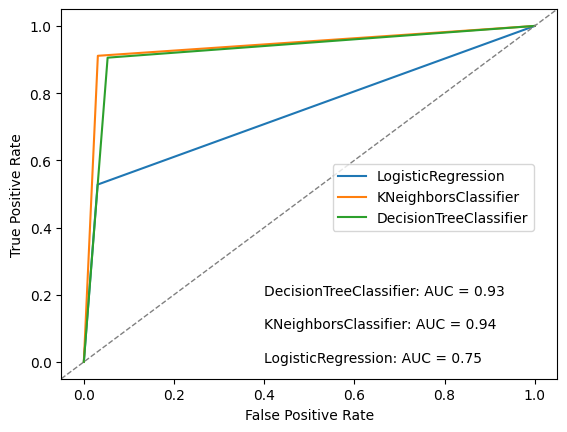

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

models = [LogisticRegression(),
          KNeighborsClassifier(),
          DecisionTreeClassifier()]

perf = {}

for model in models:
    model_name = type(model).__name__
    print(model_name)
    label,pred = cross_validate(model, X, y)
    fpr, tpr, _ = roc_curve(label, pred)
    auc = roc_auc_score(label, pred)
    perf[model_name] = {'fpr':fpr,'tpr':tpr,'auc':auc}


fig = plt.figure()

import matplotlib.pyplot as plt

i = 0
for model_name, model_perf in perf.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],
             label=model_name)
    plt.text(0.4, i, model_name + ': AUC = '+
             str(round(model_perf['auc'],2)))
    i += 0.1

plt.axline((0, 0), (1, 1), linestyle="--", lw=1, color='gray')
plt.legend(loc='upper center', bbox_to_anchor=(0.75, 0.6))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.savefig('roc_multimethods.png', bbox_inches='tight', dpi=300)

# Precision-recall curve (PRC)

**Sensitivity or Recall**:
Proportion of true positive example among ALL positive (P)
	\begin{equation}
		Sensitivity = Recall = \frac{TP}{TP+FN} = \frac{TP}{P}
	\end{equation}

**Precision**:
Proportion of true positive example among \textbf{the predicted positive} (PP)
	\begin{equation}
		Precision = \frac{TP}{PP}
	\end{equation}
**F1-score**: F1 = 2 $\times$ (precision $\times$ recall) / (precision + recall)

Precision is very important in many circumstances, e.g.,
* We can only afford testing 5 drugs among 100 predicted drugs
* We can admit a small number of high-risk patients among all patients

Let's compare ROC and Precision-Recall on two simulated cancer/healthy datassets using the two simulation function below. One has 50% positively labelled ($N_1$ = 900) and 50% negatively labelled examples ($N_0=900$) and the other one has only 1% positively labelled ($N_1$=10) and 99% negatively labelled ($N_0$=900) examples.

In [ ]:
def simulate_prostate_cancer_data_balanced():
    # simulate normal samples
    npoints = 300
    means = [70, 70]
    # cov = [[90,40],[40,50]]
    cov = [[120, 60], [60, 50]]
    np.random.seed(3)

    normal1 = np.random.multivariate_normal(means, cov, npoints)
    labels_normal1 = np.zeros((npoints, 1))
    npoints = 300
    means = [140, 60]
    # cov = [[90,40],[40,50]]
    cov = [[160, 30], [30, 50]]

    normal2 = np.random.multivariate_normal(means, cov, npoints)
    labels_normal2 = np.zeros((npoints, 1))

    npoints = 300
    means = [250, 110]
    # cov = [[90,40],[40,50]]
    cov = [[300, 30], [30, 30]]

    normal3 = np.random.multivariate_normal(means, cov, npoints)
    labels_normal3 = np.zeros((npoints, 1))

    normal = np.concatenate((normal1, normal2, normal3))
    labels_normal = np.concatenate((labels_normal1, labels_normal2, labels_normal3))

    # simulate cancer samples
    npoints = 450
    means = [155, 80]
    # cov = [[150,50],[50,50]]
    cov = [[4000, -600], [-600, 50]]

    cancer1 = np.random.multivariate_normal(means, cov, npoints)
    labels_cancer1 = np.ones((npoints, 1))

    npoints = 450
    means = [50, 80]
    # cov = [[150,50],[50,50]]
    cov = [[40, -60], [-60, 50]]

    cancer2 = np.random.multivariate_normal(means, cov, npoints)
    labels_cancer2 = np.ones((npoints, 1))

    cancer = np.concatenate((cancer1, cancer2))
    labels_cancer = np.concatenate((labels_cancer1, labels_cancer2))

    X = np.concatenate((normal, cancer), axis=0)
    y = np.concatenate((labels_normal, labels_cancer), axis=0)

    y = y[:,0]

    return X, y


def simulate_prostate_cancer_data_imbalanced():
    # simulate normal samples
    npoints = 300
    means=[70,70]
    #cov = [[90,40],[40,50]]
    cov = [[120,60],[60,50]]
    np.random.seed(3)

    normal1 = np.random.multivariate_normal(means,cov, npoints)
    labels_normal1 = np.zeros((npoints, 1))
    npoints = 300
    means=[140,60]
    #cov = [[90,40],[40,50]]
    cov = [[160,30],[30,50]]

    normal2 = np.random.multivariate_normal(means,cov, npoints)
    labels_normal2 = np.zeros((npoints, 1))

    npoints = 300
    means=[250,110]
    #cov = [[90,40],[40,50]]
    cov = [[300,30],[30,30]]

    normal3 = np.random.multivariate_normal(means,cov, npoints)
    labels_normal3 = np.zeros((npoints, 1))

    normal=np.concatenate((normal1,normal2,normal3))
    labels_normal=np.concatenate((labels_normal1,labels_normal2,labels_normal3))

    # simulate cancer samples
    npoints = 5
    means=[155,80]
    #cov = [[150,50],[50,50]]
    cov = [[4000,-600],[-600,50]]

    cancer1 = np.random.multivariate_normal(means,cov, npoints)
    labels_cancer1 = np.ones((npoints, 1))

    npoints = 5
    means=[50,80]
    #cov = [[150,50],[50,50]]
    cov = [[40,-60],[-60,50]]

    cancer2 = np.random.multivariate_normal(means,cov, npoints)
    labels_cancer2 = np.ones((npoints, 1))

    cancer=np.concatenate((cancer1,cancer2))
    labels_cancer=np.concatenate((labels_cancer1,labels_cancer2))

    X= np.concatenate((normal,cancer), axis=0)
    y = np.concatenate((labels_normal,labels_cancer), axis=0)

    y = y[:,0]

    return X, y

We will compare three methods:
1. random prediction: probabilities sampled from a uniform distribution
2. KNN (K=5)
3. Decision Tree (default settings)

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

### Method comparison ###
def evaluate(balanced=True):

    models = [KNeighborsClassifier(), DecisionTreeClassifier()]

    if balanced:
        X,y = simulate_prostate_cancer_data_balanced()
    else:
        X, y = simulate_prostate_cancer_data_imbalanced()

    perf = {}

    # ROC and PRC for random prediction
    pred = np.random.rand(y.shape[0])
    fpr, tpr, _ = roc_curve(y, pred)
    auroc = roc_auc_score(y, pred)
    precision, recall, thresholds = precision_recall_curve(y, pred)
    auprc = auc(recall, precision)
    perf["random"] = {'fpr': fpr, 'tpr': tpr, 'auroc': auroc,
                      'precision':precision,'recall':recall,'auprc':auprc}

    for model in models:
        model_name = type(model).__name__
        print(model_name)
        label,pred = cross_validate(model, X, y)

        # compute ROC and AUROC
        fpr, tpr, _ = roc_curve(label, pred)
        auroc = roc_auc_score(label, pred)

        # compute PRC and AUPRC
        precision, recall, _ = precision_recall_curve(label, pred)
        auprc = auc(recall, precision)

        perf[model_name] = {'fpr':fpr,'tpr':tpr,'auroc':auroc,
                            'precision':precision,'recall':recall,'auprc':auprc}

    return perf

def plot_roc(perf, balanced=True):
    plt.clf()
    i = 0
    for model_name, model_perf in perf.items():
        plt.plot(model_perf['fpr'], model_perf['tpr'],label=model_name)
        plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
        i += 0.1

    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='upper center', bbox_to_anchor=(0.35, 0.8))

    if balanced:
        plt.savefig('roc_balanced.png', bbox_inches='tight', dpi=300)
    else:
        plt.savefig('roc_imbalanced.png', bbox_inches='tight', dpi=300)


def plot_prc(perf, balanced=True):
    plt.clf()
    i = 0
    if balanced:
        i += 0.4
    for model_name, model_perf in perf.items():
        plt.plot(model_perf['recall'], model_perf['precision'],label=model_name)
        plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auprc'],2)))
        i += 0.1

    plt.xlabel("Recall")
    plt.ylabel("Precision")

    if balanced:
        plt.legend(bbox_to_anchor=(0.5, 0.8))
        plt.savefig('prc_balanced.png', bbox_inches='tight', dpi=300)
    else:
        plt.legend(bbox_to_anchor=(0.5, 0.75))
        plt.savefig('prc_imbalanced.png', bbox_inches='tight', dpi=300)

For balanced data (P=900,N=900), the ROC curve for the random prediction goes along the diagonal.

KNeighborsClassifier
DecisionTreeClassifier


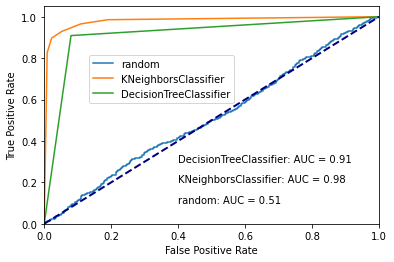

In [ ]:
perf_balanced = evaluate(balanced=True)
plot_roc(perf_balanced, balanced=True)

However, for imbalanced data (P=10,N=900), random prediction will no lobger follow the diagnoal line

KNeighborsClassifier
DecisionTreeClassifier


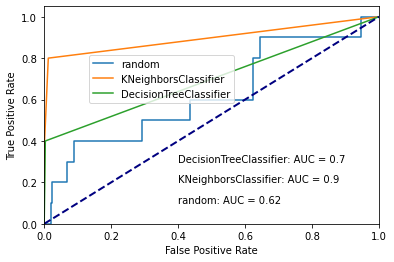

In [ ]:
perf_unbalanced = evaluate(balanced=False)
plot_roc(perf_unbalanced, balanced=False)

On the other hand, precision-recall is more sensitive in distinguishing random predictions from the other real methods especially when the data are imbalanced

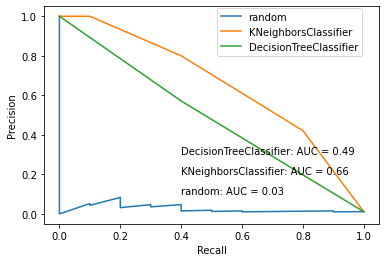

In [ ]:
plot_prc(perf_unbalanced, balanced=False)

When evaluated on balanced data, PRC still does a descent job in distinguishing random from real methods.

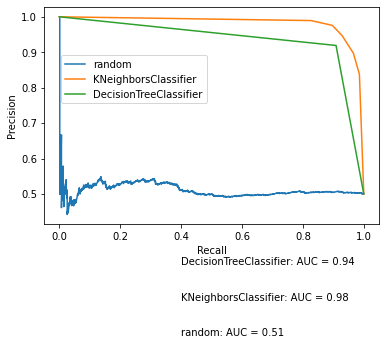

In [ ]:
plot_prc(perf_balanced, balanced=True)

# Conclusion

ROC may be easier to interpret (AUPRC 50% for balanced data). When data are imbalanced and precision is  important, Precision-recall is a better choice. Usually people report both AUROC and AUPRC along with other metrics that we will see in later lectures.